In [2]:
# Important libraries

from numba import njit
import networkx as nx
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme()
np.random.seed(4440)

In [3]:
# Functions

@njit
def Erdos_Renyi_Network(N,p):
    connections = np.zeros(shape=(N,N), dtype='bool')
    
    for node in range(N-1):
            node_connections = np.random.rand(N-1-node) < p
            connections[node, node+1:] = node_connections
            connections[node+1:, node] = node_connections
    return connections
    

def Small_World_Network(N, k, p):
    connections = np.zeros(shape=(N,N), dtype='bool')
    max_dist = int(k/2)

    for i in range(1, max_dist+1):
        connections[range(i, N), range(0, N-i)] = True
        connections[range(0, N-i), range(i, N)] = True
        connections[range(N-i, N), range(0, i)] = True
        connections[range(0, i), range(N-i, N)] = True
    
    for neighbor_dist in range(1, max_dist+1):
        for i in range(N):
            j = (i+neighbor_dist)%N
            rand_num = np.random.rand()
            
            if rand_num <= p:
                connections[i,j]=False
                connections[j,i]=False
                
                while True:
                    rand_j = np.random.randint(0,N)
                    
                    if (connections[i,rand_j]==False) and (rand_j!=i):
                        connections[i,rand_j]=True
                        connections[rand_j,i]=True
                        break
    return connections


def Scale_Free_Network(N, gamma, ymin, ymax):
    scale_free_rand_num = lambda x,gamma,ymin,ymax: ((ymax**(1-gamma) - ymin**(1-gamma))*x +\
                                                      ymin**(1-gamma))**(1/(1-gamma))
    
    connections = np.zeros(shape=(N,N), dtype='bool')
    initial_cons = np.sort(np.rint(scale_free_rand_num(np.random.rand(N), gamma, ymin, ymax+1)).astype(int))[::-1]
    
    if initial_cons.sum()%2: initial_cons[initial_cons.argmax()] -= 1
    conns_for_each_node = initial_cons.copy()

    main_list = [i for i in range(1,N)]
    secondary_list = main_list[:]

    idx_x = 0
    idx_y = 0
    while len(main_list) != 0:
        if (len(secondary_list) == 0) or (conns_for_each_node[idx_x] == 0):
            idx_x += 1
            try: main_list.remove(idx_x)
            except: pass
            secondary_list = main_list[:]
            
        else:
            while (len(secondary_list) != 0) and (conns_for_each_node[idx_x] != 0):
                idx_y = np.random.choice(secondary_list)
                
                if (conns_for_each_node[idx_y] > 0) and (connections[idx_x, idx_y]==False):
                    connections[idx_x, idx_y]=True
                    connections[idx_y, idx_x]=True
                    conns_for_each_node[idx_x] -= 1
                    conns_for_each_node[idx_y] -= 1
                    
                    secondary_list.remove(idx_y)
                    if conns_for_each_node[idx_y] == 0: main_list.remove(idx_y)
                    
                else: 
                    print('-->', secondary_list, conns_for_each_node[idx_y], connections[idx_x, idx_y], idx_x, idx_y)
                    input()
            
    return connections


def least_squares_regression(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    a = ((x - mean_x)*(y - mean_y)).sum()/((x - mean_x)**2).sum()
    b = mean_y - a * mean_x
    return a,b


def loadingbar(n,NMC):
    if NMC >= 10:
        if (n + 1) % NMC == 0: print(f"{n+1:.0e}")
        elif (n + 1) % int(NMC/10) == 0: print(f".", end="")
    else:
        if (n + 1) % 1 == 0: print(f"{n+1:0.e}")
        elif (n + 1) % NMC == 0: print(f".", end="")

<h3>P_4.1</h3>

N = 1e+03 | .........1e+03
mean = 166.50
theo_diff = 0.100%

N = 1e+04 | .........1e+03
mean = 1666.54
theo_diff = 0.008%

time = 418 sec




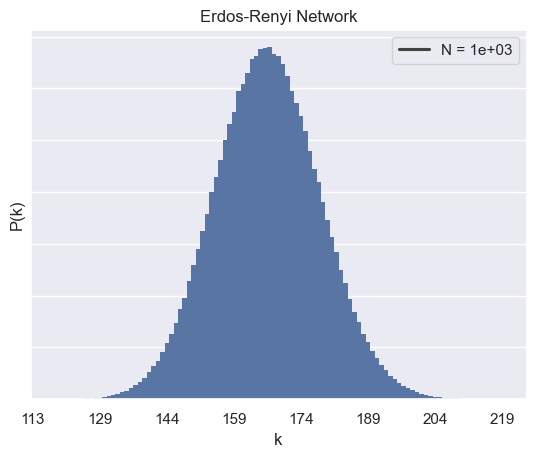

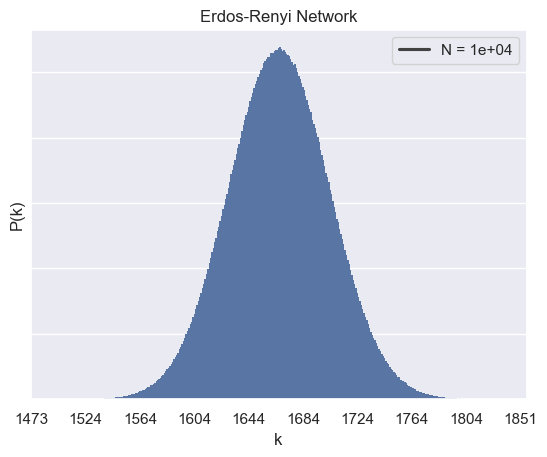

In [4]:
NMC = 10**3
N_nodes = [10**3, 10**4]
p_con = 1/6

start = time.time()
dicts = [{} for _ in range(len(N_nodes))]

for i,N in enumerate(N_nodes):
    print(f"N = {N:.0e} |", end=' ')
    
    for n in range(NMC):
        nodes_conns = Erdos_Renyi_Network(N,p_con).sum(axis=0)
        conns_freq = np.unique(nodes_conns, return_counts=True)

        for val, freq in zip(conns_freq[0],conns_freq[1]):
           dicts[i][val] = dicts[i].get(val,0) + freq/N/NMC
        loadingbar(n,NMC)

    mean = 0
    for val,freq in dicts[i].items():
        mean += val*freq
    print(f'mean = {mean:.2f}')
    print(f'απόκλιση = {abs(p_con*N - mean)*100/(p_con*N):.3f}%\n')

print(f'time = {round(time.time() - start)} sec\n\n')
for i,_dict in enumerate(dicts):
    sns.barplot(_dict, width=1, lw=0.)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.title("Erdos-Renyi Network")
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.yticks(visible=False)
    plt.legend([f'N = {N_nodes[i]:1.0e}'])
    plt.show()

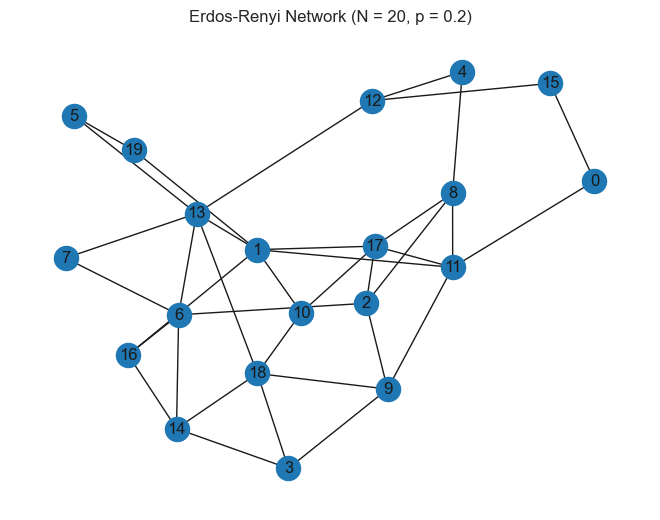

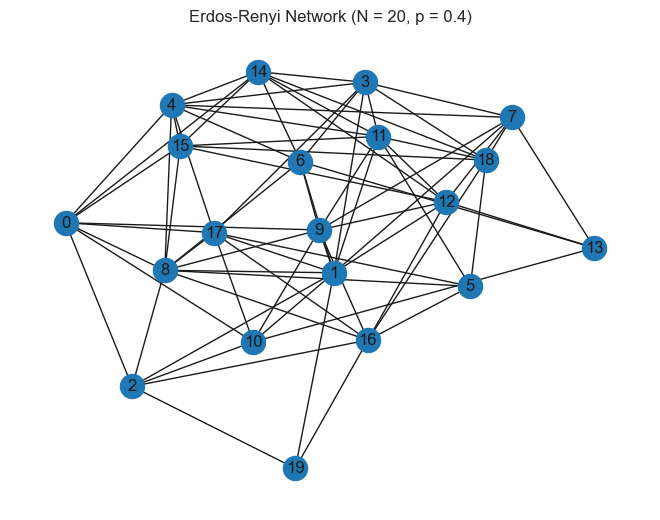

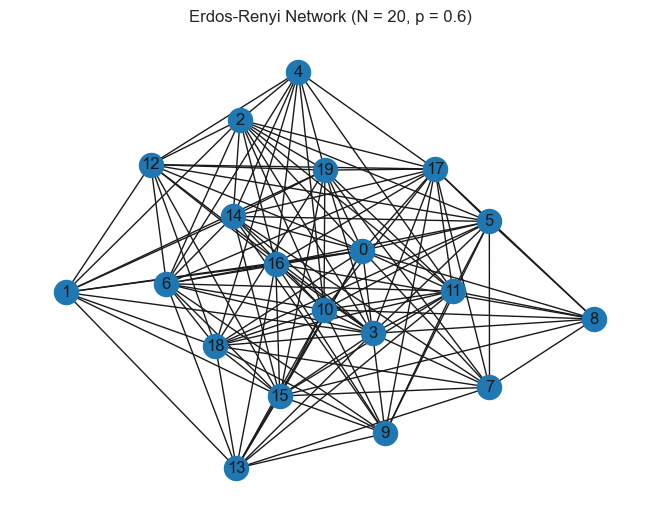

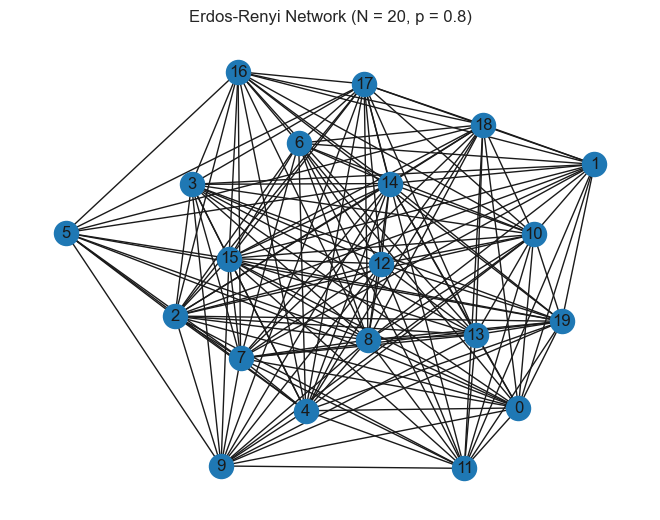

In [5]:
N_nodes = 20
p_con = {0.2,0.4,0.6,0.8}

for p in p_con:
    connections = Erdos_Renyi_Network(N_nodes, p)
    
    G = nx.from_numpy_array(connections)
    nx.draw(G, with_labels=True)
    plt.title(f"Erdos-Renyi Network (N = {N_nodes}, p = {p})")
    plt.show()

<h3>P_4.2</h3>

.........1e+03
time = 11 sec




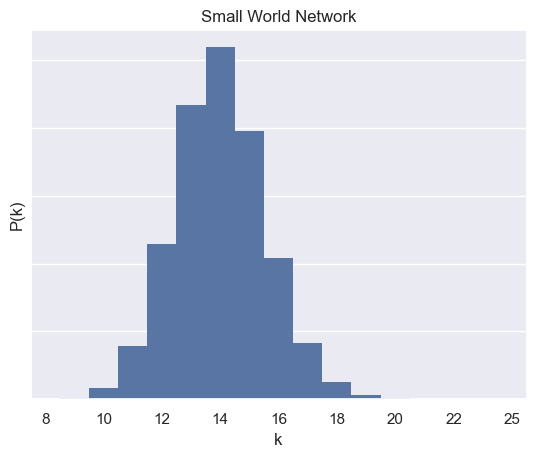

In [6]:
NMC = 10**3
N_nodes = 10**3
k = 14 # k even number
p_red = 0.2

start = time.time()
dict_ = {}

for n in range(NMC):                        
    nodes_conns = Small_World_Network(N_nodes, k, p_red).sum(axis=0)
    conns_freq = np.unique(nodes_conns, return_counts=True)

    for val, freq in zip(conns_freq[0],conns_freq[1]):
       dict_[val] = dict_.get(val,0) + freq/N_nodes/NMC
    loadingbar(n,NMC)
            
print(f'time = {round(time.time() - start)} sec\n\n')
sns.barplot(dict_, width=1, lw=0.)
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title("Small World Network")
plt.xlabel('k')
plt.ylabel('P(k)')
plt.yticks(visible=False)
plt.show()

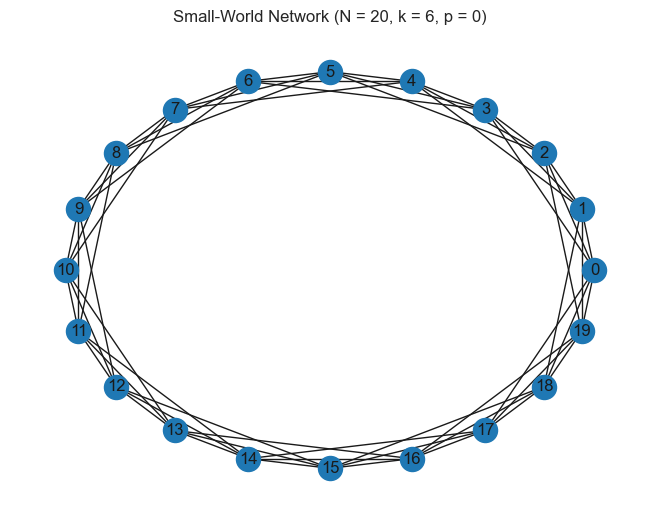

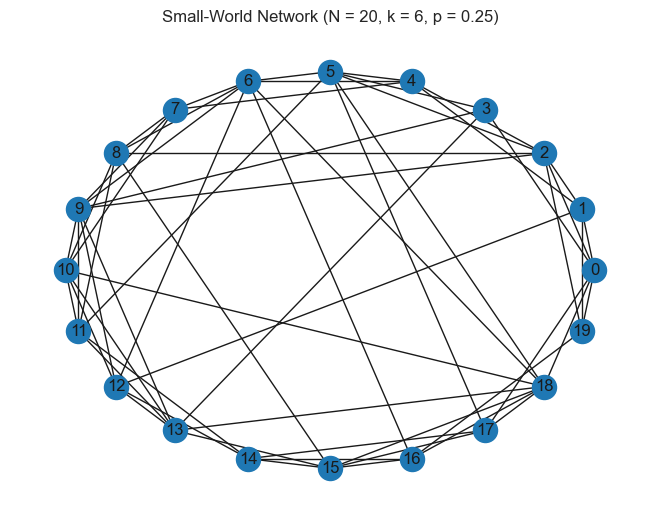

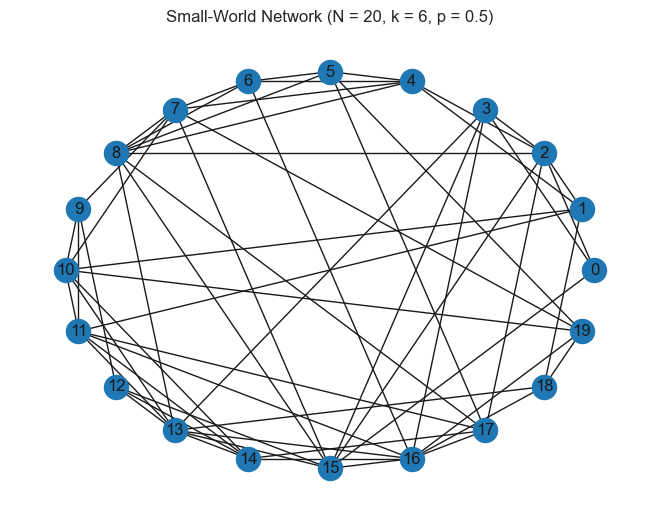

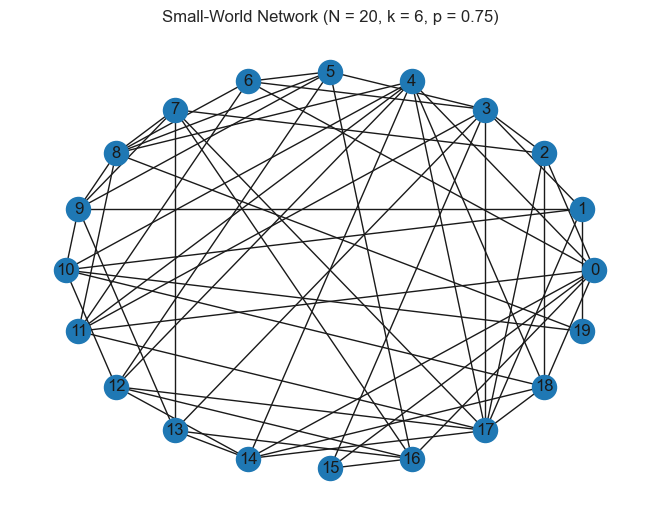

In [7]:
N_nodes = 20
k = 6 # k even number
p_red = {0, 0.25, 0.5, 0.75}

for p in p_red:
    connections = Small_World_Network(N_nodes, k, p)
    
    G = nx.from_numpy_array(connections)
    nx.draw_circular(G, with_labels=True)
    plt.title(f"Small-World Network (N = {N_nodes}, k = {k}, p = {p})")
    plt.show()

<h3>P_4.3</h3>

γ = 2.0 | .........1e+03
γ = 2.5 | .........1e+03
γ = 3.0 | .........1e+03
γ = 4.0 | .........1e+03

γ = 2.0 | y = -1.930*x - 0.164
απόκλιση = 3.51%

γ = 2.5 | y = -2.411*x - 0.003
απόκλιση = 3.57%

γ = 3.0 | y = -2.884*x + 0.088
απόκλιση = 3.88%

γ = 4.0 | y = -3.764*x + 0.120
απόκλιση = 5.90%


time = 2 sec



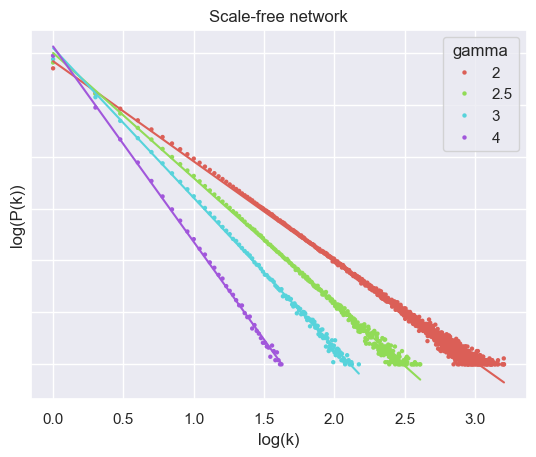

In [29]:
NMC = 10**3
N_nodes = 10**4
gammas = [2, 2.5, 3, 4] # gamma != 1

ymin = 1
ymax = N_nodes - 1

dicts = [{} for _ in gammas]
start = time.time()

scale_free_rand_num = lambda x, gamma,ymin,ymax: ((ymax**(1-gamma) - ymin**(1-gamma))*x +\
                                                   ymin**(1-gamma))**(1/(1-gamma))

for i, gamma in enumerate(gammas):
    print(f"γ = {gamma:.1f} | ", end="")
    
    for n in range(NMC):
        nodes_conns = np.floor(scale_free_rand_num(np.random.random(N_nodes), gamma, 1, ymax+1)).astype(int)
        conns_freq = np.unique(nodes_conns, return_counts=True)
    
        for val, freq in zip(conns_freq[0],conns_freq[1]):
            dicts[i][val] = dicts[i].get(val,0) + freq/(N_nodes*NMC)
        loadingbar(n,NMC)

print()
df = pd.DataFrame.from_dict(dicts, orient='columns').T
df.reset_index(inplace=True)
df.columns = ['k']+gammas
df.sort_values(by='k', ignore_index=True, inplace=True)
df = df[df >= 10/(N_nodes*NMC)].dropna(thresh=2)
df.reset_index(drop=True, inplace=True)
log_df = df.apply(np.log10)

colors = sns.color_palette("hls", len(gammas))
for color,gamma in zip(colors, gammas):
    x = log_df[['k',gamma]].dropna().k
    y = log_df[['k',gamma]].dropna()[gamma]
    a,b = least_squares_regression(x, y)

    sns.lineplot(x=x, y=a*x+b, color=color)
    print(f'γ = {gamma:.1f} | y = {a:.3f}*x {"+" if (b > 0) else "-"} {abs(b):.3f}')
    print(f"απόκλιση = {abs(gamma-(-a))*100/gamma:.2f}%\n")

print(f'\ntime = {round(time.time() - start)} sec\n')
dfm = log_df.melt(id_vars='k', var_name='gamma', value_name='vals')
sns.scatterplot(data=dfm, x='k', y='vals', hue='gamma', palette=colors, lw=0, s=10)
plt.title("Scale-free network")
plt.xlabel('log(k)')
plt.ylabel('log(P(k))')
plt.yticks(visible=False)
plt.show()

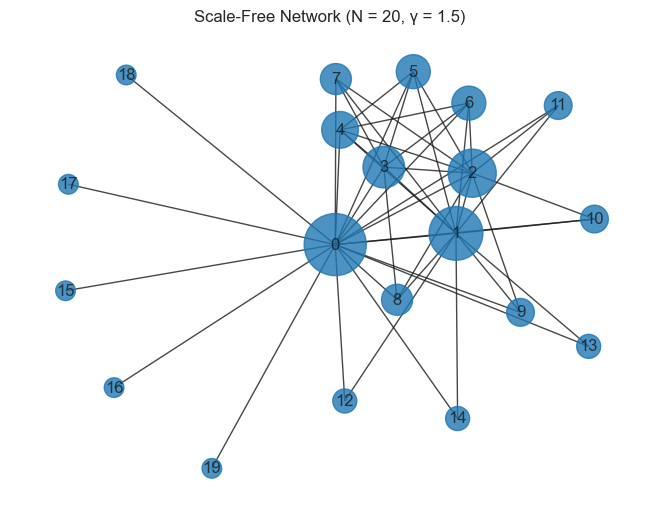

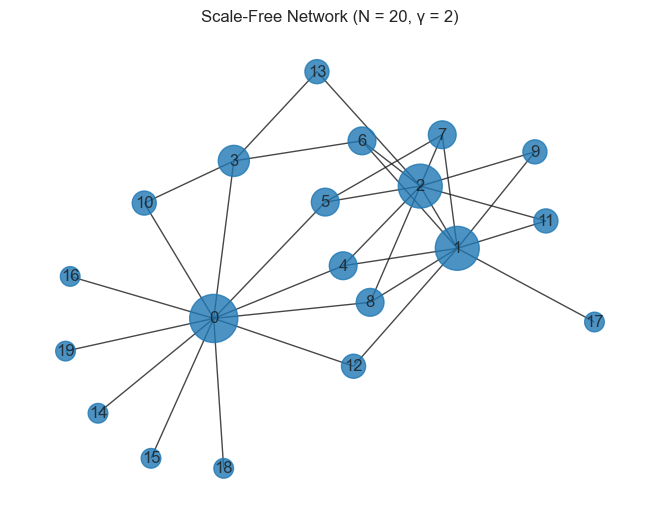

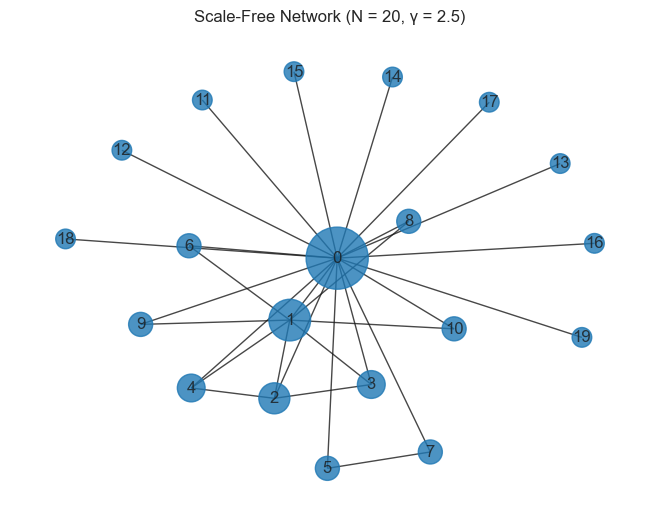

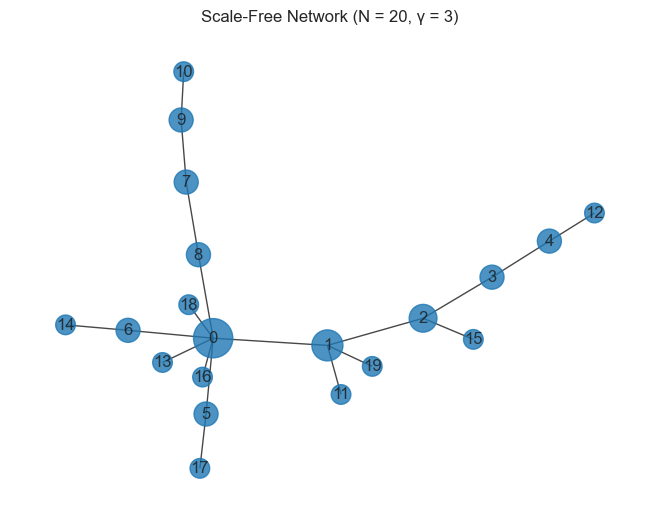

In [23]:
N_nodes = 20
gammas = [1.5, 2, 2.5, 3] # gamma != 1

ymin = 1
ymax = N_nodes -1

for gamma in gammas:
    connections = Scale_Free_Network(N_nodes, gamma, ymin, ymax)
    
    G = nx.from_numpy_array(connections)
    degrees = dict(G.degree)
    node_sizes = {node: (degree+1)*100  for node, degree in degrees.items()}
    nx.draw_spring(G, with_labels=True, node_size=list(node_sizes.values()), alpha=0.8)
    plt.title(f"Scale-Free Network (N = {N_nodes}, γ = {gamma})")
    plt.show()